# Qiskit 5 -2020/2021

1. [C<sup>n</sup>NOT decomposition](#decomp)
2. [Quantum state Tomography](#tomo)
3. [Measurement Error Mitigation](#mit)
4. [Bernstein-Vazirani Algorithm](#bva)

&nbsp;

#### Module imports

In [65]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, transpile

from qiskit.tools.visualization import plot_histogram

&nbsp;

# 1.  C<sup>n</sup>NOT decomposition<a id='decomp'></a>

&nbsp;

What happens if we try to run the function for a larger number of variables (i.e. input qubits), or a larger number of clauses (i.e. f_out qubits)?

You will find that the algorithm will have to apply multiple C<sup>n</sup>NOTs, with n being the number of controls necessary to perform a NOT operation on the target qubit. This means not only larger f_in and f_out, but also more auxiliary qubits (for decomposition).

Admit the following decomposition scheme for a C<sup>n</sup>NOT gate (reference [1]):

<img src="https://www.researchgate.net/profile/Peter-Russer/publication/225931473/figure/fig2/AS:383053693243397@1468338525711/Decomposition-of-the-multiply-controlled-NOT-gate-C-k-X-into-2-k-1-TOFFOLI-gates_W640.jpg" width="500 px" align="center">


<div class="alert alert-block alert-warning">

**Exercise 4.2 - C<sup>n</sup>NOT decomposition**

&nbsp;

From the scheme above, build a function `cn_not` to decompose a C<sup>n</sup>NOT with an arbitrary number of controls into Toffoli and CNOT gates. 

The function should take as arguments the quantum circuit, **a list of control qubits** (this is different from a qubit register), a target qubit, and a register of auxiliary qubits.

</div>

In [76]:
def cn_not(circuit, ctrls, trg, aux):
    n = len(ctrls)
    
    if(n>2):
        circuit.ccx(ctrls[0],ctrls[1],aux[0])
        for i in range(2,n):
            circuit.ccx(ctrls[i],aux[i-2],aux[i-1])
            
        circuit.cx(aux[-1],trg)
        
        for i in range(n-1,1,-1):
            circuit.ccx(ctrls[i],aux[i-2],aux[i-1])
        circuit.ccx(ctrls[0],ctrls[1],aux[0])
        

<div class="alert alert-block alert-warning">

We can test the function - let's admit that controls are contained in a single quantum register:
    
</div>

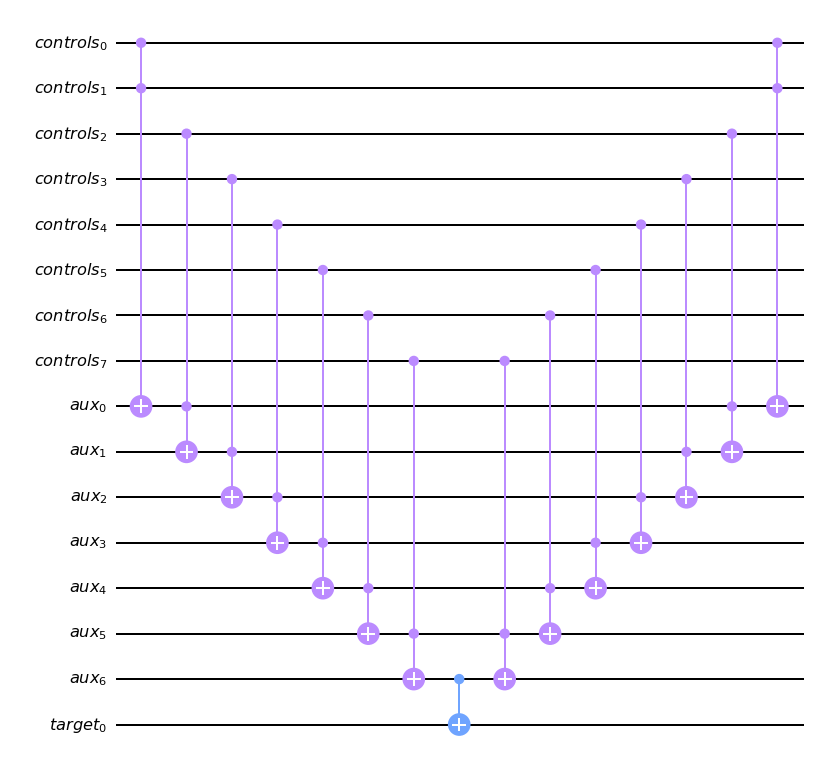

In [77]:
# Number of controls
n=8

controls=QuantumRegister(n, 'controls')
aux=QuantumRegister(n-1, 'aux')
trg=QuantumRegister(1, 'target')
qc=QuantumCircuit(controls, aux, trg)

control_list = []
for i in range(n):
    control_list.append(controls[i])
    
cn_not(qc, control_list, trg, aux)

qc.draw(output='mpl')

**Refs**

1. "[Quantum computing algorithm for electromagnetic field simulation](https://www.researchgate.net/publication/225931473_Quantum_computing_algorithm_for_electromagnetic_field_simulation)"

# 2. Quantum State Tomography<a id='tomo'></a>

&nbsp;

**Tomography** is a method of imaging a three-dimensional object, and its internal structure, through observation of different cross-sections of the object.

<img src="https://upload.wikimedia.org/wikipedia/commons/2/25/TomographyPrinciple_Illustration.png" width="400 px" align="center">

&nbsp;

Similarly, **quantum state tomography** is the process of reconstructing the density matrix describing a quantum system, through different quantum state measurements of the system.

<img src="https://d3i71xaburhd42.cloudfront.net/4279329f29c293c2bd1e0092e5c6b329c907ea29/5-Figure2-1.png" width="500 px" align="center">

&nbsp;

The density matrix allows for the representation of any mixed states, i.e. statistical mixtures of pure states:

$$ \rho = \sum_j p_j |\psi_j \rangle \langle \psi_j| $$

For pure states, $j=1$

**Module imports**

In [2]:
# Noise simulation
from qiskit.providers.aer import noise

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# Interactive tools
import qiskit.tools.jupyter

# Plotting function
from matplotlib import pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<div class="alert alert-block alert-info">
    
**Example** 

How to perform 2-qubit state tomography:

</div>

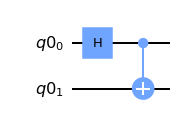

In [3]:
# Create the expected density matrix

qr = QuantumRegister(2)
bell = QuantumCircuit(qr)
bell.h(qr[0])
bell.cx(qr[0], qr[1])

bell.draw(output='mpl')

In [4]:
# Get statevector representation

job = execute(bell, Aer.get_backend('statevector_simulator'))
psi_bell = job.result().get_statevector(bell)
print(psi_bell)

[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


In [5]:
rho_bell = np.outer(psi_bell, np.conj(psi_bell))
rho_bell

array([[0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j],
       [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
       [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
       [0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j]])

/home/gil/.local/lib/python3.8/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:468: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += circuit
/home/gil/.local/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
/home/gil/.local/lib/python3.8/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = prep + meas
/home/gil/.local/lib/python3.8/sit

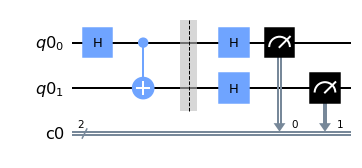

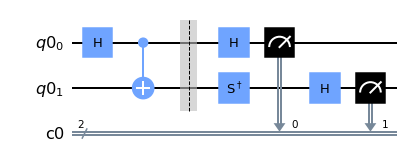

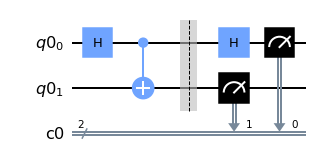

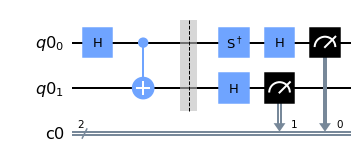

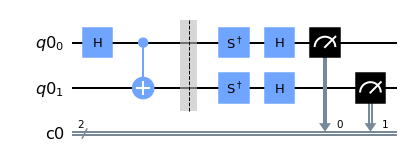

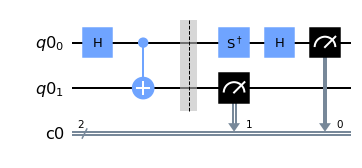

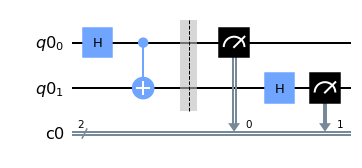

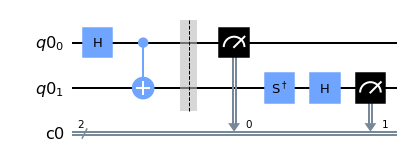

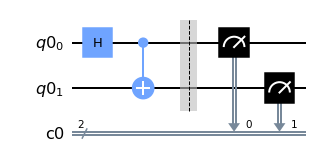

In [6]:
# Creating the tomography circuits

qst_bell = state_tomography_circuits(bell, [qr[0],qr[1]])

for circuit in qst_bell:
    circuit.draw(output='mpl')

In [8]:
# Executing and fitting the circuits

job = execute(qst_bell, Aer.get_backend('qasm_simulator'), shots=1000)

tomo_fitter_bell = StateTomographyFitter(job.result(), qst_bell)

# Perform the tomography fit
# which outputs a density matrix
experimental_bell = tomo_fitter_bell.fit()

np.around(experimental_bell, decimals=3)

array([[ 0.517+0.j   , -0.   -0.007j, -0.011+0.001j,  0.494-0.001j],
       [-0.   +0.007j,  0.002+0.j   , -0.002+0.j   , -0.001+0.004j],
       [-0.011-0.001j, -0.002-0.j   ,  0.002+0.j   , -0.011+0.002j],
       [ 0.494+0.001j, -0.001-0.004j, -0.011-0.002j,  0.479+0.j   ]])

<div class="alert alert-block alert-info">
    

**Fidelity of quantum states**

&nbsp;

Given two density operators $\rho$ and $\sigma$, the fidelity is generally defined as the quantity 

&nbsp;

$$F(\rho, \sigma) = \left[\operatorname{tr} \sqrt{\sqrt\rho \sigma\sqrt\rho}\right]^2$$

&nbsp;

Or, when comparing the fidelity between two pure states


$$F(\rho, \sigma)=|\langle\psi_\rho|\psi_\sigma\rangle|^2$$

</div>

In [9]:
# Obtaining reconstructed state fidelity

F_bell = state_fidelity(psi_bell, experimental_bell)
print('Fit Fidelity =', F_bell)

Fit Fidelity = 0.9926180318184924


## 2.1 Quantum state tomography with measurement noise

&nbsp;

State reconstruction methods are experimentally useful in the determination of quantum states of physical devices, since we may want to test a device's reliability or suceptibility to noise. 

But how does tomography when the measurement process itself is noisy? 

In [18]:
IBMQ.save_account('9bdd0926fd08f6f0b88d29bfe8fec7952382b222b3aa00d774032c6c73a831db81be1d58f08f0ca0af7f1cf1a1e425c5646e0573960c0c6f409d8d08049d608d')

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [19]:
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

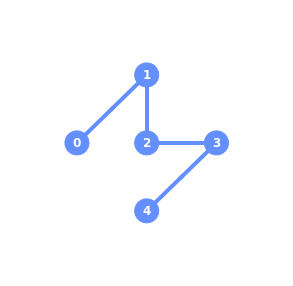

ImportError: Must have seaborn installed to use plot_error_map. To install, run "pip install seaborn".

<IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>

In [20]:
provider = IBMQ.get_provider(hub='ibm-q')

backend = provider.get_backend('ibmq_athens')

backend

<div class="alert alert-block alert-info">

**Noise models**

&nbsp;

**Aer** simulators allow for the specification of custom noise models.

</div>

In [21]:
# Or, for simetric noise

noise_rate = 0.1
noise_model = noise.NoiseModel()

for qi in range(qr.__len__()):
    read_err = noise.errors.readout_error.ReadoutError([[1-noise_rate, noise_rate],[noise_rate,1-noise_rate]])
    noise_model.add_readout_error(read_err,[qi])

In [22]:
# We can now re-run the simulation by adding the noise model to the execution inistruction:

backend = Aer.get_backend('qasm_simulator')
job_tomo_exemp = execute(qst_bell, backend=backend, shots=1000, noise_model=noise_model)

tomo_bell  = StateTomographyFitter(job_tomo_exemp.result(), qst_bell)

experimental_bell = tomo_bell.fit()

F_bell_mn = state_fidelity(psi_bell, experimental_bell)
print('Fit Fidelity w/ measuremt noise=', F_bell_mn)

Fit Fidelity w/ measuremt noise= 0.737137876726107


<div class="alert alert-block alert-warning">

**Exercise 1**

&nbsp;

Implement a routine to estimate the fit fidelity of the quantum tomography procedure associated with the `bell` circuit, for measurement noise rates `[0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]`.

Use the matplotlib `plt` function to plot the fidelity as function of noise rate.

</div>

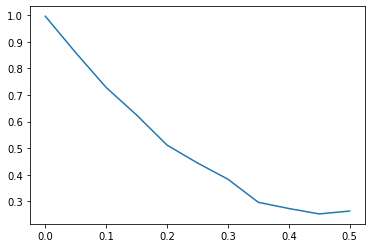

In [23]:
noise_rates =[0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
backend = Aer.get_backend('qasm_simulator')
F_bell=[]
for rate in noise_rates:
    
    noise_rate = rate
    noise_model = noise.NoiseModel()

    for qi in range(qr.__len__()):
        read_err = noise.errors.readout_error.ReadoutError([[1-noise_rate, noise_rate],[noise_rate,1-noise_rate]])
        noise_model.add_readout_error(read_err,[qi])
    
    job_tomo_exemp = execute(qst_bell, backend=backend, shots=1000, noise_model=noise_model)

    tomo_bell  = StateTomographyFitter(job_tomo_exemp.result(), qst_bell)

    experimental_bell = tomo_bell.fit()

    F_bell.append(state_fidelity(psi_bell, experimental_bell))

plt.plot(noise_rates, F_bell)
plt.show()

# 3. Measurement Error Mitigation<a id='mit'></a>

The measurement calibration is used to mitigate measurement errors.

In [24]:
# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

### Calibration Matrices

**1** Generate a list of measurement calibration circuits.

Each circuit creates a basis state.

Since there we measure 5 qubits, we need $2^5 = 32$ calibration circuits.

In [25]:
# Generate the calibration circuits
qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1], qr=qr, circlabel='mcal')

In [26]:
state_labels

['00', '01', '10', '11']

#### Computing the calibration matrix

If there was no noise in the device the calibration matrix would be a identity matrix $32 \times 32$. Since we compute this matrix with a real quantum device there is going to be some noise. 

We could do this step with simulated noise from Qiskit Aer. 

In [30]:
backend = provider.get_backend('ibmq_athens')

In [31]:
job_ignis = execute(meas_calibs, backend=backend)

jobID_run_ignis = job_ignis.job_id()

print('JOB ID: {}'.format(jobID_run_ignis))

JOB ID: 608817f9df209c8605d84887


In [32]:
job_get=backend.retrieve_job("608817f9df209c8605d84887")

cal_results = job_get.result()

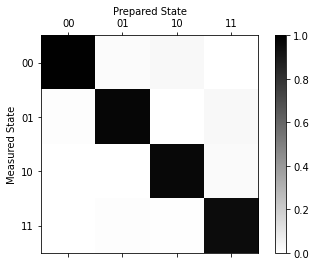

In [33]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

# Plot the calibration matrix
meas_fitter.plot_calibration()

#### Analysing results

The average assignment fidelity is the trace of the previous matrix.

In [35]:
# What is the measurement fidelity?
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

Average Measurement Fidelity: 0.968994


### Applying Calibration

In [44]:
bell.measure_all()
bell.draw()

┌───┐      ░ ┌─┐    ░ ┌─┐   
   q0_0: ┤ H ├──■───░─┤M├────░─┤M├───
         └───┘┌─┴─┐ ░ └╥┘┌─┐ ░ └╥┘┌─┐
   q0_1: ─────┤ X ├─░──╫─┤M├─░──╫─┤M├
              └───┘ ░  ║ └╥┘ ░  ║ └╥┘
 meas: 2/══════════════╩══╩═════╬══╬═
                       0  1     ║  ║ 
                                ║  ║ 
meas3: 2/═══════════════════════╩══╩═
                                0  1

In [50]:
job_r = execute(bell, backend)

jobID_r = job_r.job_id()

print('JOB ID: {}'.format(jobID_r))

JOB ID: 6d23643f-8cf4-4bd9-a85c-fd5736ff0d8f


In [49]:
job_get=backend.retrieve_job("1622d0ea-ab5e-4210-ab6c-611f435f29de")

result_r = job_get.result()
counts_run = result_r.get_counts(bell)

AttributeError: 'QasmSimulator' object has no attribute 'retrieve_job'

In [47]:
backend = Aer.get_backend("qasm_simulator")

In [40]:
result = execute(bell, backend).result()
counts_sim = result.get_counts(bell)

Our raw data can be the `result_r`. We can apply a filter based on the calibration matrix to get mitigated counts.

In [41]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(result_r)
mitigated_counts = mitigated_results.get_counts()

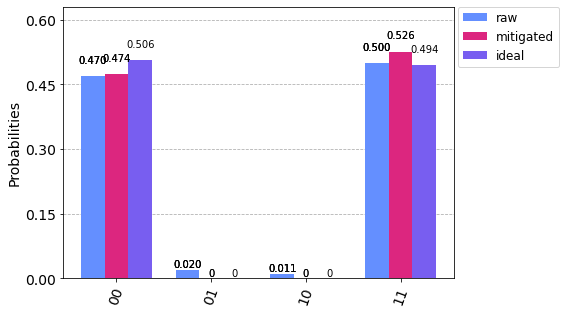

In [43]:
plot_histogram([counts_run, mitigated_counts, counts_sim], legend=['raw', 'mitigated', 'ideal'])

### Mitigating error in Example with Measurement Noise 

In [28]:
#no correction
print('State fidelity (no correction): F = {:.5f}'.format(F_bell_mn))

#correct data
correct_tomo_results = meas_fitter.filter.apply(job_tomo_exemp.result())
tomo_bell_mit = StateTomographyFitter(correct_tomo_results, qst_bell)
rho_fit_bell_mit = tomo_bell_mit.fit(method='lstsq')
F_bell_mit = state_fidelity(rho_fit_bell_mit, psi_bell)
print('State fidelity (w/ correction): F = {:.5f}'.format(F_bell_mit))

State fidelity (no correction): F = 0.72906
State fidelity (w/ correction): F = 0.75998


# 4. [Bernstein-Vazirani Algorithm](https://qiskit.org/textbook/ch-algorithms/bernstein-vazirani.html) <a id='bva'></a>

In the [Bernstein-Vazirani algorithm](https://epubs.siam.org/doi/10.1137/S0097539796300921), $f$ is a function with input $x$, which returns $x$ bitwise product with the string $s$, i.e. $$f(x)=s\cdot x ( \mod 2)$$ 

The goal is to find the $s$. 

<img src="https://qiskit.org/textbook/ch-algorithms/images/bv2.svg" width="500 px" align="center">


Initialise the inputs qubits to the $|0\rangle ^{\otimes n}$ state, and output qubit to $|−\rangle$.

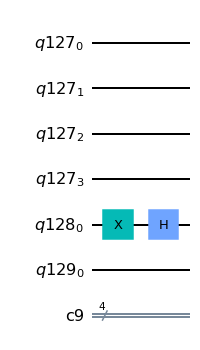

In [112]:
n = 4
qr = QuantumRegister(n)
trg = QuantumRegister(1)
auxil = QuantumRegister(1)
cr = ClassicalRegister(n)
qc = QuantumCircuit(qr,trg,auxil,cr)

qc.x(trg)
qc.h(trg)

qc.draw(output='mpl')

Apply Hadamard gates to the input register.

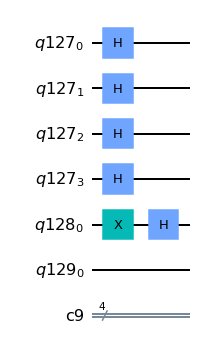

In [113]:
qc.h(qr)
qc.draw(output='mpl')

Oracle for $s = 1011$.

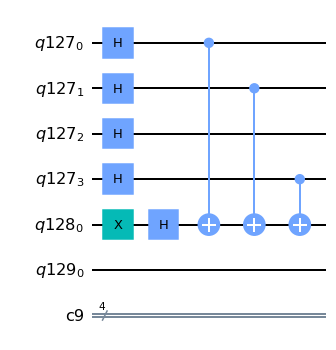

In [114]:
s="1011"
s = s[::-1]
for i in range(len(s)):
    if (int(s[i])):
        qc.cx(qr[i],trg)
qc.draw(output='mpl')

Apply Hadamard gates to the input register.

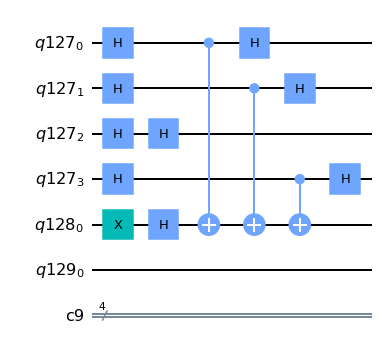

In [115]:
qc.h(qr)
qc.draw(output='mpl')

Measure.

In [116]:
for i in range(n):
    qc.measure(qr[i], cr[i])

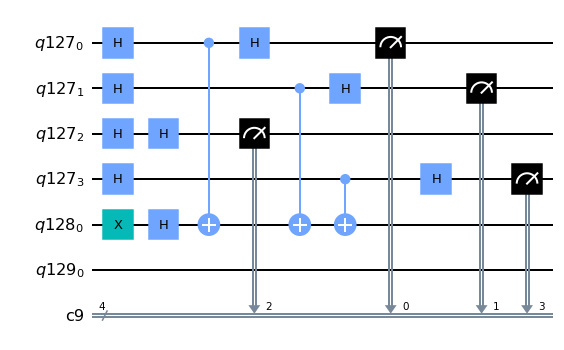

In [117]:
qc.draw(output='mpl')

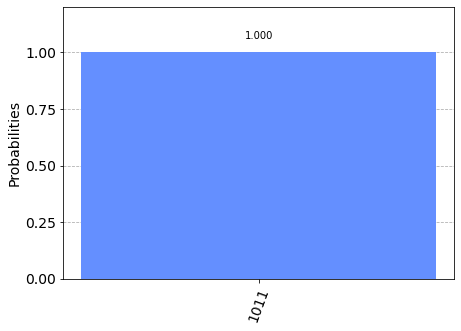

In [120]:
from qiskit import assemble
qasm_sim = Aer.get_backend('qasm_simulator')
shots = 1024
qobj = assemble(qc)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)